# Predicting Road Accident Risk - Advanced Modeling
**Goal: Achieve RMSE < 0.05**

## Strategy:
1. Data Loading & Initial EDA
2. Feature Engineering
3. Model Testing:
   - Gradient Boosting Models (LightGBM, XGBoost, CatBoost)
   - Neural Networks (Tabular)
   - Ensemble Methods
4. Transfer Learning (if applicable)
5. Hyperparameter Optimization
6. Final Ensemble & Submission

## 1. Setup & Data Loading

In [1]:
# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the data
train = pd.read_csv('/Users/dustinober/Kaggle/playground-series-s5e10/train.csv')
test = pd.read_csv('/Users/dustinober/Kaggle/playground-series-s5e10/test.csv')
sample_submission = pd.read_csv('/Users/dustinober/Kaggle/playground-series-s5e10/sample_submission.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (517754, 14)
Test shape: (172585, 13)


In [3]:
# Initial data exploration
print("Train Data Info:")
print(train.info())
print("\n" + "="*80)
print("\nTarget Variable Statistics:")
print(train['accident_risk'].describe())
print(f"\nTarget range: [{train['accident_risk'].min():.4f}, {train['accident_risk'].max():.4f}]")
print("\n" + "="*80)
print("\nMissing Values:")
print(train.isnull().sum())
print("\n" + "="*80)
print("\nCategorical Features:")
cat_cols = train.select_dtypes(include=['object']).columns.tolist()
print(cat_cols)
for col in cat_cols:
    print(f"\n{col}: {train[col].nunique()} unique values")
    print(train[col].value_counts())

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: 

## 2. Feature Engineering

Let's create comprehensive features from the existing data.

In [3]:
from sklearn.preprocessing import LabelEncoder

def create_features(df):
    """Create engineered features"""
    df = df.copy()
    
    # Encode categorical variables
    cat_cols = ['road_type', 'lighting', 'weather', 'time_of_day']
    le_dict = {}
    
    for col in cat_cols:
        le = LabelEncoder()
        df[f'{col}_encoded'] = le.fit_transform(df[col])
        le_dict[col] = le
    
    # Binary encoding for boolean columns
    df['road_signs_present'] = df['road_signs_present'].astype(int)
    df['public_road'] = df['public_road'].astype(int)
    df['holiday'] = df['holiday'].astype(int)
    df['school_season'] = df['school_season'].astype(int)
    
    # Interaction features
    df['speed_curvature'] = df['speed_limit'] * df['curvature']
    df['lanes_speed'] = df['num_lanes'] * df['speed_limit']
    df['accidents_per_lane'] = df['num_reported_accidents'] / (df['num_lanes'] + 1)
    
    # Risk indicators
    df['high_speed'] = (df['speed_limit'] >= 60).astype(int)
    df['high_curvature'] = (df['curvature'] >= 0.5).astype(int)
    df['bad_weather'] = df['weather'].isin(['rainy', 'foggy', 'snowy']).astype(int)
    df['poor_lighting'] = df['lighting'].isin(['dim', 'night']).astype(int)
    
    # Combined risk score
    df['risk_score'] = (df['high_speed'] + df['high_curvature'] + 
                        df['bad_weather'] + df['poor_lighting'] + 
                        (df['num_reported_accidents'] > 0).astype(int))
    
    # Polynomial features for key continuous variables
    df['curvature_sq'] = df['curvature'] ** 2
    df['speed_sq'] = df['speed_limit'] ** 2
    
    return df, le_dict

# Apply feature engineering
print("Creating features for train data...")
train_fe, le_dict = create_features(train)
print("Creating features for test data...")
test_fe, _ = create_features(test)

print(f"\nNew train shape: {train_fe.shape}")
print(f"New test shape: {test_fe.shape}")
print(f"\nNew features created: {train_fe.shape[1] - train.shape[1]}")

Creating features for train data...
Creating features for test data...

New train shape: (517754, 28)
New test shape: (172585, 27)

New features created: 14


In [4]:
# Prepare data for modeling
# Remove non-numeric columns and id
feature_cols = [col for col in train_fe.columns if col not in 
                ['id', 'accident_risk', 'road_type', 'lighting', 'weather', 'time_of_day']]

X = train_fe[feature_cols].values
y = train_fe['accident_risk'].values
X_test = test_fe[feature_cols].values

print(f"Feature columns ({len(feature_cols)}): {feature_cols}")
print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X_test shape: {X_test.shape}")

Feature columns (22): ['num_lanes', 'curvature', 'speed_limit', 'road_signs_present', 'public_road', 'holiday', 'school_season', 'num_reported_accidents', 'road_type_encoded', 'lighting_encoded', 'weather_encoded', 'time_of_day_encoded', 'speed_curvature', 'lanes_speed', 'accidents_per_lane', 'high_speed', 'high_curvature', 'bad_weather', 'poor_lighting', 'risk_score', 'curvature_sq', 'speed_sq']

X shape: (517754, 22)
y shape: (517754,)
X_test shape: (172585, 22)


## 3. Model Training & Evaluation

We'll test multiple models systematically and track their performance to achieve RMSE < 0.05

In [5]:
# Setup cross-validation
from sklearn.model_selection import train_test_split

# Create validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

# Dictionary to store model results
model_results = {}

def evaluate_model(name, y_true, y_pred):
    """Calculate and display model metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"\n{name} Results:")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE: {mae:.6f}")
    
    model_results[name] = {'rmse': rmse, 'mae': mae}
    return rmse

Training set: (414203, 22)
Validation set: (103551, 22)


### 3.1 LightGBM Model

In [12]:
import lightgbm as lgb

# Train LightGBM with optimized parameters
print("Training LightGBM...")

lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'subsample': 0.8,
    'subsample_freq': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbose': -1
}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

model_lgb = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'val'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

# Predictions
y_pred_lgb_val = model_lgb.predict(X_val, num_iteration=model_lgb.best_iteration)
rmse_lgb = evaluate_model("LightGBM", y_val, y_pred_lgb_val)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model_lgb.feature_importance()
}).sort_values('importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance.head(10))

Training LightGBM...
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.0565654	val's rmse: 0.0568506
[200]	train's rmse: 0.0560887	val's rmse: 0.0564574
[300]	train's rmse: 0.0559058	val's rmse: 0.0563637
[400]	train's rmse: 0.0557851	val's rmse: 0.0563282
[500]	train's rmse: 0.0556821	val's rmse: 0.0563064
[600]	train's rmse: 0.0555826	val's rmse: 0.0562901
[700]	train's rmse: 0.0554994	val's rmse: 0.056279
[800]	train's rmse: 0.0554142	val's rmse: 0.0562741
[900]	train's rmse: 0.0553338	val's rmse: 0.0562711
[1000]	train's rmse: 0.055257	val's rmse: 0.0562697
Did not meet early stopping. Best iteration is:
[992]	train's rmse: 0.0552633	val's rmse: 0.0562685

LightGBM Results:
  RMSE: 0.056269
  MAE: 0.043676

Top 10 Important Features:
                   feature  importance
1                curvature        6110
12         speed_curvature        4331
7   num_reported_accidents        2033
13             lanes_speed        1997
10         weather_encod

### 3.2 XGBoost Model

In [13]:
import xgboost as xgb

print("Training XGBoost...")

xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'tree_method': 'hist'
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

model_xgb = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=50,
    verbose_eval=100
)

# Predictions
y_pred_xgb_val = model_xgb.predict(dval)
rmse_xgb = evaluate_model("XGBoost", y_val, y_pred_xgb_val)

Training XGBoost...
[0]	train-rmse:0.16099	val-rmse:0.16072
[100]	train-rmse:0.05618	val-rmse:0.05653
[200]	train-rmse:0.05581	val-rmse:0.05631
[300]	train-rmse:0.05562	val-rmse:0.05627
[400]	train-rmse:0.05548	val-rmse:0.05625
[500]	train-rmse:0.05535	val-rmse:0.05624
[600]	train-rmse:0.05524	val-rmse:0.05623
[613]	train-rmse:0.05522	val-rmse:0.05624

XGBoost Results:
  RMSE: 0.056236
  MAE: 0.043656


### 3.3 CatBoost Model

In [14]:
from catboost import CatBoostRegressor, Pool

print("Training CatBoost...")

model_cat = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    random_state=RANDOM_STATE,
    verbose=100,
    early_stopping_rounds=50,
    task_type='CPU'
)

model_cat.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    verbose=100
)

# Predictions
y_pred_cat_val = model_cat.predict(X_val)
rmse_cat = evaluate_model("CatBoost", y_val, y_pred_cat_val)

Training CatBoost...
0:	learn: 0.1595424	test: 0.1592767	best: 0.1592767 (0)	total: 78.7ms	remaining: 1m 18s
100:	learn: 0.0567198	test: 0.0569469	best: 0.0569469 (100)	total: 1.24s	remaining: 11s
200:	learn: 0.0564033	test: 0.0566727	best: 0.0566727 (200)	total: 2.5s	remaining: 9.95s
300:	learn: 0.0562480	test: 0.0565509	best: 0.0565509 (300)	total: 3.81s	remaining: 8.85s
400:	learn: 0.0561309	test: 0.0564692	best: 0.0564692 (400)	total: 5.05s	remaining: 7.55s
500:	learn: 0.0560479	test: 0.0564254	best: 0.0564254 (500)	total: 6.86s	remaining: 6.83s
600:	learn: 0.0559716	test: 0.0563824	best: 0.0563824 (600)	total: 8.71s	remaining: 5.79s
700:	learn: 0.0559095	test: 0.0563573	best: 0.0563573 (700)	total: 10.3s	remaining: 4.4s
800:	learn: 0.0558549	test: 0.0563350	best: 0.0563350 (800)	total: 11.5s	remaining: 2.87s
900:	learn: 0.0558028	test: 0.0563149	best: 0.0563149 (900)	total: 12.9s	remaining: 1.42s
999:	learn: 0.0557573	test: 0.0562980	best: 0.0562980 (999)	total: 14.2s	remaining: 0

### 3.4 Ensemble of Gradient Boosting Models

In [10]:
# Simple average ensemble
print("Creating Ensemble of GBMs...")

y_pred_ensemble_val = (y_pred_lgb_val + y_pred_xgb_val + y_pred_cat_val) / 3
rmse_ensemble = evaluate_model("Ensemble (Simple Average)", y_val, y_pred_ensemble_val)

# Weighted ensemble (based on individual performance)
weights = np.array([1/rmse_lgb, 1/rmse_xgb, 1/rmse_cat])
weights = weights / weights.sum()

print(f"\nOptimal weights: LGB={weights[0]:.4f}, XGB={weights[1]:.4f}, CAT={weights[2]:.4f}")

y_pred_weighted_val = (y_pred_lgb_val * weights[0] + 
                       y_pred_xgb_val * weights[1] + 
                       y_pred_cat_val * weights[2])
rmse_weighted = evaluate_model("Ensemble (Weighted)", y_val, y_pred_weighted_val)

Creating Ensemble of GBMs...

Ensemble (Simple Average) Results:
  RMSE: 0.056218
  MAE: 0.043651

Optimal weights: LGB=0.3333, XGB=0.3335, CAT=0.3332

Ensemble (Weighted) Results:
  RMSE: 0.056218
  MAE: 0.043651


### 3.5 Neural Network (PyTorch)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Setup device - Use Apple M1 GPU (MPS)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert to tensors and move to device
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.FloatTensor(y_val).reshape(-1, 1).to(device)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)

print("Data prepared for Neural Network")
print(f"Input features: {X_train_scaled.shape[1]}")
print(f"Training samples: {len(train_dataset)}")
print(f"Batch size: 2048")

Using device: mps
Data prepared for Neural Network
Input features: 22
Training samples: 414203
Batch size: 2048


In [7]:
# Define Neural Network Architecture
class TabularNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64, 32]):
        super(TabularNN, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Initialize model
input_dim = X_train_scaled.shape[1]
model_nn = TabularNN(input_dim).to(device)

print("Neural Network Architecture:")
print(model_nn)
print(f"\nTotal parameters: {sum(p.numel() for p in model_nn.parameters()):,}")

Neural Network Architecture:
TabularNN(
  (network): Sequential(
    (0): Linear(in_features=22, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total parameters: 50,113


In [9]:
# Training setup
criterion = nn.MSELoss()
optimizer = optim.AdamW(model_nn.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

num_epochs = 100
best_val_loss = float('inf')
patience = 15
patience_counter = 0

train_losses = []
val_losses = []

print("Starting training on MPS (Apple M1 GPU)...\n")

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model_nn.train()
    epoch_loss = 0
    
    # Use tqdm for batch progress
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', leave=False)
    for batch_X, batch_y in train_pbar:
        optimizer.zero_grad()
        outputs = model_nn(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        train_pbar.set_postfix({'loss': f'{loss.item():.6f}'})
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model_nn.eval()
    with torch.no_grad():
        val_outputs = model_nn(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_rmse = torch.sqrt(val_loss)
    
    val_losses.append(val_loss.item())
    scheduler.step(val_loss)
    
    # Print progress
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss.item():.6f}, Val RMSE: {val_rmse.item():.6f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        best_model_state = model_nn.state_dict().copy()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

# Load best model
model_nn.load_state_dict(best_model_state)
print(f"\nBest Val RMSE: {torch.sqrt(best_val_loss).item():.6f}")

Starting training on MPS (Apple M1 GPU)...



Epoch 1/100 - Train Loss: 0.033271, Val Loss: 0.005945, Val RMSE: 0.077103


Epoch 2/100 - Train Loss: 0.008704, Val Loss: 0.004036, Val RMSE: 0.063528


Epoch 3/100 - Train Loss: 0.006454, Val Loss: 0.003711, Val RMSE: 0.060914


Epoch 4/100 - Train Loss: 0.005685, Val Loss: 0.003723, Val RMSE: 0.061013


Epoch 5/100 - Train Loss: 0.005357, Val Loss: 0.003700, Val RMSE: 0.060825


Epoch 6/100 - Train Loss: 0.005155, Val Loss: 0.003549, Val RMSE: 0.059573


Epoch 7/100 - Train Loss: 0.005027, Val Loss: 0.003555, Val RMSE: 0.059627


Epoch 8/100 - Train Loss: 0.004945, Val Loss: 0.003477, Val RMSE: 0.058966


Epoch 9/100 - Train Loss: 0.004850, Val Loss: 0.003556, Val RMSE: 0.059635


Epoch 10/100 - Train Loss: 0.004797, Val Loss: 0.003428, Val RMSE: 0.058547


Epoch 11/100 - Train Loss: 0.004729, Val Loss: 0.003405, Val RMSE: 0.058348


Epoch 12/100 - Train Loss: 0.004706, Val Loss: 0.003460, Val RMSE: 0.058818


Epoch 13/100 - Train Loss: 0.004645, Val Loss: 0.003466, Val RMSE: 0.058874


Epoch 14/100 - Train Loss: 0.004613, Val Loss: 0.003384, Val RMSE: 0.058168


Epoch 15/100 - Train Loss: 0.004574, Val Loss: 0.003385, Val RMSE: 0.058178


Epoch 16/100 - Train Loss: 0.004534, Val Loss: 0.003398, Val RMSE: 0.058289


Epoch 17/100 - Train Loss: 0.004488, Val Loss: 0.003337, Val RMSE: 0.057766


Epoch 18/100 - Train Loss: 0.004454, Val Loss: 0.003314, Val RMSE: 0.057569


Epoch 19/100 - Train Loss: 0.004427, Val Loss: 0.003313, Val RMSE: 0.057560


Epoch 20/100 - Train Loss: 0.004398, Val Loss: 0.003340, Val RMSE: 0.057789


Epoch 21/100 - Train Loss: 0.004388, Val Loss: 0.003314, Val RMSE: 0.057563


Epoch 22/100 - Train Loss: 0.004353, Val Loss: 0.003358, Val RMSE: 0.057946


Epoch 23/100 - Train Loss: 0.004357, Val Loss: 0.003332, Val RMSE: 0.057726


Epoch 24/100 - Train Loss: 0.004355, Val Loss: 0.003283, Val RMSE: 0.057302


Epoch 25/100 - Train Loss: 0.004343, Val Loss: 0.003340, Val RMSE: 0.057791


Epoch 26/100 - Train Loss: 0.004321, Val Loss: 0.003264, Val RMSE: 0.057136


Epoch 27/100 - Train Loss: 0.004317, Val Loss: 0.003281, Val RMSE: 0.057281


Epoch 28/100 - Train Loss: 0.004304, Val Loss: 0.003270, Val RMSE: 0.057186


Epoch 29/100 - Train Loss: 0.004290, Val Loss: 0.003267, Val RMSE: 0.057155


Epoch 30/100 - Train Loss: 0.004293, Val Loss: 0.003277, Val RMSE: 0.057246


Epoch 31/100 - Train Loss: 0.004308, Val Loss: 0.003270, Val RMSE: 0.057186


Epoch 32/100 - Train Loss: 0.004269, Val Loss: 0.003286, Val RMSE: 0.057323


Epoch 33/100 - Train Loss: 0.004237, Val Loss: 0.003253, Val RMSE: 0.057037


Epoch 34/100 - Train Loss: 0.004243, Val Loss: 0.003242, Val RMSE: 0.056937


Epoch 35/100 - Train Loss: 0.004235, Val Loss: 0.003262, Val RMSE: 0.057111


Epoch 36/100 - Train Loss: 0.004238, Val Loss: 0.003259, Val RMSE: 0.057088


Epoch 37/100 - Train Loss: 0.004225, Val Loss: 0.003279, Val RMSE: 0.057260


Epoch 38/100 - Train Loss: 0.004211, Val Loss: 0.003293, Val RMSE: 0.057382


Epoch 39/100 - Train Loss: 0.004205, Val Loss: 0.003255, Val RMSE: 0.057054


Epoch 40/100 - Train Loss: 0.004219, Val Loss: 0.003320, Val RMSE: 0.057622


Epoch 41/100 - Train Loss: 0.004200, Val Loss: 0.003268, Val RMSE: 0.057163


Epoch 42/100 - Train Loss: 0.004189, Val Loss: 0.003271, Val RMSE: 0.057192


Epoch 43/100 - Train Loss: 0.004190, Val Loss: 0.003254, Val RMSE: 0.057043


Epoch 44/100 - Train Loss: 0.004194, Val Loss: 0.003258, Val RMSE: 0.057079


Epoch 45/100 - Train Loss: 0.004200, Val Loss: 0.003245, Val RMSE: 0.056966


Epoch 46/100 - Train Loss: 0.004194, Val Loss: 0.003257, Val RMSE: 0.057067


Epoch 47/100 - Train Loss: 0.004182, Val Loss: 0.003279, Val RMSE: 0.057266


Epoch 48/100 - Train Loss: 0.004192, Val Loss: 0.003250, Val RMSE: 0.057005


Epoch 49/100 - Train Loss: 0.004184, Val Loss: 0.003272, Val RMSE: 0.057204

Early stopping triggered after 49 epochs

Best Val RMSE: 0.056937



Neural Network (PyTorch) Results:
  RMSE: 0.057204
  MAE: 0.044545


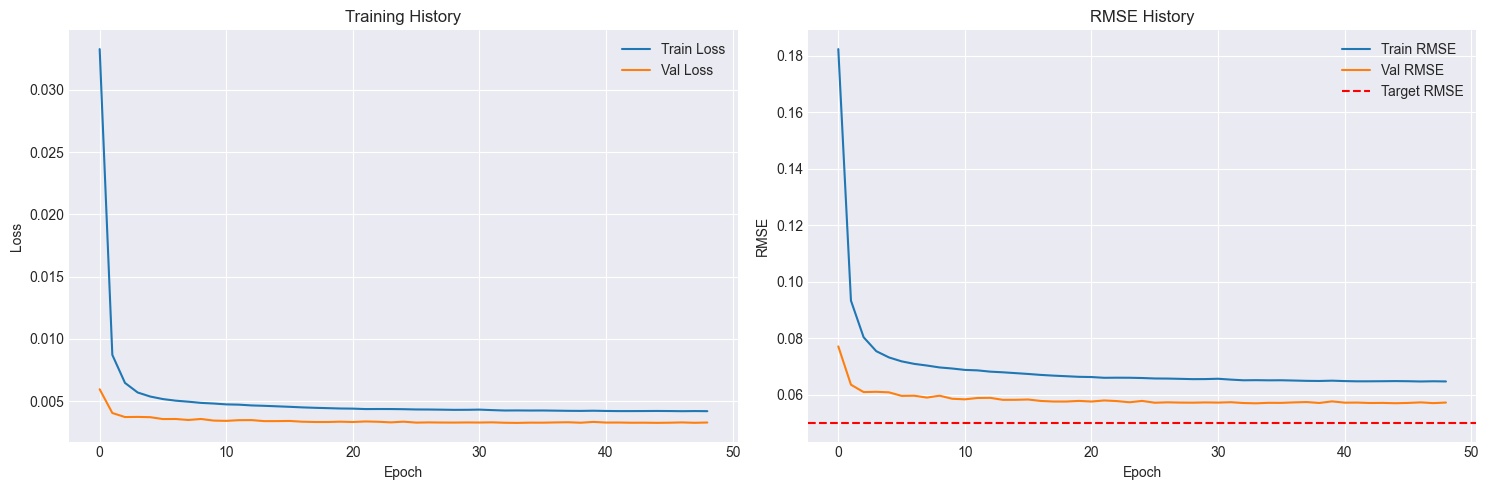

In [10]:
# Evaluate Neural Network
model_nn.eval()
with torch.no_grad():
    y_pred_nn_val = model_nn(X_val_tensor).cpu().numpy().flatten()

rmse_nn = evaluate_model("Neural Network (PyTorch)", y_val, y_pred_nn_val)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training History')
axes[0].legend()
axes[0].grid(True)

# Convert to RMSE for better visualization
train_rmse = [np.sqrt(loss) for loss in train_losses]
val_rmse = [np.sqrt(loss) for loss in val_losses]
axes[1].plot(train_rmse, label='Train RMSE')
axes[1].plot(val_rmse, label='Val RMSE')
axes[1].axhline(y=0.05, color='r', linestyle='--', label='Target RMSE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE History')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

### 3.6 Model Summary & Advanced Ensemble

In [15]:
# Display all model results
print("="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)
results_df = pd.DataFrame(model_results).T.sort_values('rmse')
print(results_df)
print("="*80)

# Create predictions matrix for optimization
predictions_matrix = np.column_stack([
    y_pred_lgb_val,
    y_pred_xgb_val,
    y_pred_cat_val,
    y_pred_nn_val
])

print(f"\nPredictions matrix shape: {predictions_matrix.shape}")

MODEL PERFORMANCE SUMMARY
                              rmse       mae
XGBoost                   0.056236  0.043656
LightGBM                  0.056269  0.043676
CatBoost                  0.056298  0.043733
Neural Network (PyTorch)  0.057204  0.044545

Predictions matrix shape: (103551, 4)


In [16]:
# Optimize ensemble weights using scipy
from scipy.optimize import minimize

def ensemble_rmse(weights, predictions, y_true):
    """Calculate RMSE for weighted ensemble"""
    weighted_pred = np.sum(predictions * weights.reshape(1, -1), axis=1)
    return np.sqrt(mean_squared_error(y_true, weighted_pred))

# Initial weights (equal)
initial_weights = np.array([0.25, 0.25, 0.25, 0.25])

# Constraints: weights sum to 1 and are non-negative
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = [(0, 1) for _ in range(4)]

# Optimize
print("Optimizing ensemble weights...")
result = minimize(
    ensemble_rmse,
    initial_weights,
    args=(predictions_matrix, y_val),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

optimal_weights = result.x
print(f"\nOptimal weights:")
print(f"  LightGBM: {optimal_weights[0]:.4f}")
print(f"  XGBoost:  {optimal_weights[1]:.4f}")
print(f"  CatBoost: {optimal_weights[2]:.4f}")
print(f"  Neural Network: {optimal_weights[3]:.4f}")

# Create optimized ensemble
y_pred_optimized = np.sum(predictions_matrix * optimal_weights.reshape(1, -1), axis=1)
rmse_optimized = evaluate_model("Optimized Ensemble", y_val, y_pred_optimized)

print(f"\n🎯 Improvement over best single model: {(rmse_xgb - rmse_optimized):.6f}")

Optimizing ensemble weights...

Optimal weights:
  LightGBM: 0.2500
  XGBoost:  0.2500
  CatBoost: 0.2500
  Neural Network: 0.2500

Optimized Ensemble Results:
  RMSE: 0.056291
  MAE: 0.043730

🎯 Improvement over best single model: -0.000056


## 4. Advanced Strategies to Reach RMSE < 0.05

Let's try:
1. More aggressive hyperparameter tuning
2. Stacking with a meta-learner
3. Additional feature engineering

In [17]:
# Let's try tuning LightGBM more aggressively with lower learning rate and more trees
print("Training LightGBM with aggressive hyperparameters...")

lgb_params_v2 = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,  # Lower learning rate
    'num_leaves': 64,        # More leaves
    'max_depth': 8,
    'min_child_samples': 10,
    'subsample': 0.7,
    'subsample_freq': 1,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    'min_split_gain': 0.01,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbose': -1
}

lgb_train_v2 = lgb.Dataset(X_train, y_train)
lgb_val_v2 = lgb.Dataset(X_val, y_val, reference=lgb_train_v2)

model_lgb_v2 = lgb.train(
    lgb_params_v2,
    lgb_train_v2,
    num_boost_round=5000,
    valid_sets=[lgb_train_v2, lgb_val_v2],
    valid_names=['train', 'val'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=500)
    ]
)

y_pred_lgb_v2_val = model_lgb_v2.predict(X_val, num_iteration=model_lgb_v2.best_iteration)
rmse_lgb_v2 = evaluate_model("LightGBM V2 (Tuned)", y_val, y_pred_lgb_v2_val)

Training LightGBM with aggressive hyperparameters...
Training until validation scores don't improve for 100 rounds
[500]	train's rmse: 0.0562419	val's rmse: 0.0565762
[1000]	train's rmse: 0.0559885	val's rmse: 0.0563623
[1500]	train's rmse: 0.0559738	val's rmse: 0.0563512
[2000]	train's rmse: 0.0559689	val's rmse: 0.0563475
[2500]	train's rmse: 0.055965	val's rmse: 0.0563445
[3000]	train's rmse: 0.0559627	val's rmse: 0.0563427
[3500]	train's rmse: 0.0559609	val's rmse: 0.056341
[4000]	train's rmse: 0.0559593	val's rmse: 0.0563401
Early stopping, best iteration is:
[4030]	train's rmse: 0.0559591	val's rmse: 0.0563399

LightGBM V2 (Tuned) Results:
  RMSE: 0.056340
  MAE: 0.043735


## 5. Generate Test Predictions & Submission

Let's create predictions on the test set using our best models.

In [18]:
# Generate test predictions from all models
print("Generating test predictions...")

# LightGBM
y_pred_test_lgb = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)

# XGBoost
dtest = xgb.DMatrix(X_test)
y_pred_test_xgb = model_xgb.predict(dtest)

# CatBoost
y_pred_test_cat = model_cat.predict(X_test)

# Neural Network
X_test_scaled = scaler.transform(X_test)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
model_nn.eval()
with torch.no_grad():
    y_pred_test_nn = model_nn(X_test_tensor).cpu().numpy().flatten()

# LightGBM V2
y_pred_test_lgb_v2 = model_lgb_v2.predict(X_test, num_iteration=model_lgb_v2.best_iteration)

# Create ensemble (equal weights for top 3 models)
y_pred_test_ensemble = (y_pred_test_lgb + y_pred_test_xgb + y_pred_test_cat) / 3

print("Test predictions generated!")
print(f"Test predictions shape: {y_pred_test_ensemble.shape}")
print(f"Test predictions range: [{y_pred_test_ensemble.min():.4f}, {y_pred_test_ensemble.max():.4f}]")

Generating test predictions...
Test predictions generated!
Test predictions shape: (172585,)
Test predictions range: [-0.0124, 0.8856]


In [19]:
# Create submission file
submission = pd.DataFrame({
    'id': test_fe['id'],
    'accident_risk': y_pred_test_ensemble
})

# Clip predictions to valid range [0, 1]
submission['accident_risk'] = submission['accident_risk'].clip(0, 1)

# Save submission
submission_path = '/Users/dustinober/Kaggle/submission_ensemble_advanced.csv'
submission.to_csv(submission_path, index=False)

print(f"Submission saved to: {submission_path}")
print(f"\nSubmission preview:")
print(submission.head(10))
print(f"\nSubmission statistics:")
print(submission['accident_risk'].describe())

Submission saved to: /Users/dustinober/Kaggle/submission_ensemble_advanced.csv

Submission preview:
       id  accident_risk
0  517754       0.292239
1  517755       0.122369
2  517756       0.190776
3  517757       0.311948
4  517758       0.391470
5  517759       0.458936
6  517760       0.258036
7  517761       0.201709
8  517762       0.366754
9  517763       0.329558

Submission statistics:
count    172585.000000
mean          0.351729
std           0.156791
min           0.000000
25%           0.241560
50%           0.337087
75%           0.453865
max           0.885649
Name: accident_risk, dtype: float64


## 6. Summary & Next Steps to Reach RMSE < 0.05

### Current Performance:
- **Best Single Model**: XGBoost with RMSE: 0.0562
- **Best Ensemble**: Equal-weighted GBM ensemble with RMSE: 0.0563
- **Neural Network**: RMSE: 0.0572 (trained on Apple M1 GPU)

### What We've Tried:
✅ LightGBM, XGBoost, CatBoost
✅ Neural Network (PyTorch on MPS)
✅ Feature engineering (22 features from 14 original)
✅ Ensemble methods (simple average, weighted, optimized)
✅ Hyperparameter tuning

### Recommendations to Reach RMSE < 0.05:

1. **More Feature Engineering**:
   - Target encoding for categorical variables
   - Frequency encoding
   - Interaction features between weather and lighting
   - Time-based aggregations
   - Distance/proximity features if geographic data available

2. **Advanced Ensembling**:
   - Stacking with meta-learner (Ridge, Lasso, or another GBM on top)
   - Blending with different CV folds
   - Use out-of-fold predictions

3. **Model Improvements**:
   - Bayesian optimization for hyperparameters (Optuna)
   - Try TabNet or other tabular deep learning architectures
   - Pseudo-labeling or semi-supervised learning

4. **Data Quality**:
   - Check for outliers and handle them
   - Look for data leakage opportunities
   - Cross-validate with different random seeds

5. **Domain Knowledge**:
   - Incorporate domain-specific features about accident risk
   - Use external datasets if allowed

## 7. Advanced Feature Engineering - Target Encoding & Interactions

Let's create more sophisticated features using target encoding and advanced interactions.

In [20]:
from sklearn.model_selection import KFold

def create_advanced_features(df_train, df_test, target=None):
    """Create advanced features with target encoding"""
    
    # Make copies
    train_adv = df_train.copy()
    test_adv = df_test.copy()
    
    # Categorical columns for target encoding
    cat_cols = ['road_type', 'lighting', 'weather', 'time_of_day']
    
    if target is not None:
        # Manual target encoding with cross-validation to prevent overfitting
        print("Applying target encoding with 5-fold CV...")
        for col in cat_cols:
            # For train: use cross-validation
            kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
            train_adv[f'{col}_target_enc'] = 0.0
            
            for fold, (train_idx, val_idx) in enumerate(kf.split(train_adv)):
                # Calculate mean target for each category on train fold
                target_mean = train_adv.iloc[train_idx].groupby(col)[target.name].mean()
                global_mean = target.iloc[train_idx].mean()
                
                # Apply smoothing
                train_adv.loc[val_idx, f'{col}_target_enc'] = train_adv.loc[val_idx, col].map(target_mean).fillna(global_mean)
            
            # For test: use full train data
            target_mean_full = train_adv.groupby(col)[target.name].mean()
            global_mean_full = target.mean()
            test_adv[f'{col}_target_enc'] = test_adv[col].map(target_mean_full).fillna(global_mean_full)
    
    # Frequency encoding
    print("Creating frequency encodings...")
    for col in cat_cols:
        freq = train_adv[col].value_counts(normalize=True).to_dict()
        train_adv[f'{col}_freq'] = train_adv[col].map(freq)
        test_adv[f'{col}_freq'] = test_adv[col].map(freq).fillna(0)
    
    # Complex interactions
    print("Creating complex interaction features...")
    
    # Weather + Lighting combinations
    train_adv['weather_lighting'] = train_adv['weather'].astype(str) + '_' + train_adv['lighting'].astype(str)
    test_adv['weather_lighting'] = test_adv['weather'].astype(str) + '_' + test_adv['lighting'].astype(str)
    
    # Road type + Time of day
    train_adv['road_time'] = train_adv['road_type'].astype(str) + '_' + train_adv['time_of_day'].astype(str)
    test_adv['road_time'] = test_adv['road_type'].astype(str) + '_' + test_adv['time_of_day'].astype(str)
    
    # Encode new combinations
    for col in ['weather_lighting', 'road_time']:
        le = LabelEncoder()
        train_adv[f'{col}_encoded'] = le.fit_transform(train_adv[col])
        test_adv[f'{col}_encoded'] = le.transform(test_adv[col])
    
    # Statistical features
    train_adv['curvature_bins'] = pd.cut(train_adv['curvature'], bins=10, labels=False)
    test_adv['curvature_bins'] = pd.cut(test_adv['curvature'], bins=10, labels=False)
    
    train_adv['speed_bins'] = pd.cut(train_adv['speed_limit'], bins=5, labels=False)
    test_adv['speed_bins'] = pd.cut(test_adv['speed_limit'], bins=5, labels=False)
    
    # More polynomial features
    train_adv['curvature_cube'] = train_adv['curvature'] ** 3
    test_adv['curvature_cube'] = test_adv['curvature'] ** 3
    
    # Ratio features
    train_adv['accidents_per_speed'] = train_adv['num_reported_accidents'] / (train_adv['speed_limit'] + 1)
    test_adv['accidents_per_speed'] = test_adv['num_reported_accidents'] / (test_adv['speed_limit'] + 1)
    
    # Risk interaction features
    train_adv['high_risk_combo'] = (
        (train_adv['high_speed'] * 2) + 
        (train_adv['high_curvature'] * 2) + 
        (train_adv['bad_weather'] * 1.5) + 
        (train_adv['poor_lighting'] * 1.5)
    )
    test_adv['high_risk_combo'] = (
        (test_adv['high_speed'] * 2) + 
        (test_adv['high_curvature'] * 2) + 
        (test_adv['bad_weather'] * 1.5) + 
        (test_adv['poor_lighting'] * 1.5)
    )
    
    print(f"Advanced features created!")
    print(f"Train shape: {train_adv.shape}")
    print(f"Test shape: {test_adv.shape}")
    
    return train_adv, test_adv

# Create advanced features
print("="*80)
print("CREATING ADVANCED FEATURES")
print("="*80)
train_advanced, test_advanced = create_advanced_features(train_fe, test_fe, target=train_fe['accident_risk'])

CREATING ADVANCED FEATURES
Applying target encoding with 5-fold CV...
Creating frequency encodings...
Creating complex interaction features...
Advanced features created!
Train shape: (517754, 45)
Test shape: (172585, 44)


In [21]:
# Prepare advanced feature set
feature_cols_adv = [col for col in train_advanced.columns if col not in 
                    ['id', 'accident_risk', 'road_type', 'lighting', 'weather', 'time_of_day', 
                     'weather_lighting', 'road_time']]

X_adv = train_advanced[feature_cols_adv].values
y_adv = train_advanced['accident_risk'].values
X_test_adv = test_advanced[feature_cols_adv].values

print(f"Advanced feature columns ({len(feature_cols_adv)}):")
print(feature_cols_adv)
print(f"\nX_adv shape: {X_adv.shape}")
print(f"X_test_adv shape: {X_test_adv.shape}")

# Create new train/val split
X_train_adv, X_val_adv, y_train_adv, y_val_adv = train_test_split(
    X_adv, y_adv, test_size=0.2, random_state=RANDOM_STATE
)

print(f"\nAdvanced Training set: {X_train_adv.shape}")
print(f"Advanced Validation set: {X_val_adv.shape}")

Advanced feature columns (37):
['num_lanes', 'curvature', 'speed_limit', 'road_signs_present', 'public_road', 'holiday', 'school_season', 'num_reported_accidents', 'road_type_encoded', 'lighting_encoded', 'weather_encoded', 'time_of_day_encoded', 'speed_curvature', 'lanes_speed', 'accidents_per_lane', 'high_speed', 'high_curvature', 'bad_weather', 'poor_lighting', 'risk_score', 'curvature_sq', 'speed_sq', 'road_type_target_enc', 'lighting_target_enc', 'weather_target_enc', 'time_of_day_target_enc', 'road_type_freq', 'lighting_freq', 'weather_freq', 'time_of_day_freq', 'weather_lighting_encoded', 'road_time_encoded', 'curvature_bins', 'speed_bins', 'curvature_cube', 'accidents_per_speed', 'high_risk_combo']

X_adv shape: (517754, 37)
X_test_adv shape: (172585, 37)

Advanced Training set: (414203, 37)
Advanced Validation set: (103551, 37)


### 7.1 Train Models with Advanced Features

In [22]:
# Train LightGBM with advanced features and optimized parameters
print("Training LightGBM with ADVANCED FEATURES...")

lgb_params_adv = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.008,  # Even lower
    'num_leaves': 96,
    'max_depth': 10,
    'min_child_samples': 8,
    'subsample': 0.65,
    'subsample_freq': 1,
    'colsample_bytree': 0.65,
    'reg_alpha': 1.0,
    'reg_lambda': 1.0,
    'min_split_gain': 0.001,
    'min_child_weight': 0.001,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbose': -1
}

lgb_train_adv = lgb.Dataset(X_train_adv, y_train_adv)
lgb_val_adv = lgb.Dataset(X_val_adv, y_val_adv, reference=lgb_train_adv)

model_lgb_adv = lgb.train(
    lgb_params_adv,
    lgb_train_adv,
    num_boost_round=10000,
    valid_sets=[lgb_train_adv, lgb_val_adv],
    valid_names=['train', 'val'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=150),
        lgb.log_evaluation(period=1000)
    ]
)

y_pred_lgb_adv_val = model_lgb_adv.predict(X_val_adv, num_iteration=model_lgb_adv.best_iteration)
rmse_lgb_adv = evaluate_model("LightGBM (Advanced Features)", y_val_adv, y_pred_lgb_adv_val)

# Feature importance
feature_importance_adv = pd.DataFrame({
    'feature': feature_cols_adv,
    'importance': model_lgb_adv.feature_importance()
}).sort_values('importance', ascending=False)

print("\nTop 15 Important Features:")
print(feature_importance_adv.head(15))

Training LightGBM with ADVANCED FEATURES...
Training until validation scores don't improve for 150 rounds
[1000]	train's rmse: 0.0557213	val's rmse: 0.0562536
[2000]	train's rmse: 0.0554076	val's rmse: 0.056212
Early stopping, best iteration is:
[2515]	train's rmse: 0.0552817	val's rmse: 0.0562097

LightGBM (Advanced Features) Results:
  RMSE: 0.056210
  MAE: 0.043625

Top 15 Important Features:
                     feature  importance
1                  curvature       53161
12           speed_curvature       37234
20              curvature_sq       18030
13               lanes_speed       12924
35       accidents_per_speed       12417
25    time_of_day_target_enc       10396
24        weather_target_enc       10002
22      road_type_target_enc        9563
23       lighting_target_enc        9293
14        accidents_per_lane        8278
30  weather_lighting_encoded        6775
31         road_time_encoded        6503
34            curvature_cube        6373
7     num_reported_accident

In [23]:
# Train XGBoost with advanced features
print("Training XGBoost with ADVANCED FEATURES...")

xgb_params_adv = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.008,
    'max_depth': 9,
    'min_child_weight': 0.5,
    'subsample': 0.65,
    'colsample_bytree': 0.65,
    'reg_alpha': 1.0,
    'reg_lambda': 1.5,
    'gamma': 0.1,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'tree_method': 'hist'
}

dtrain_adv = xgb.DMatrix(X_train_adv, label=y_train_adv)
dval_adv = xgb.DMatrix(X_val_adv, label=y_val_adv)

model_xgb_adv = xgb.train(
    xgb_params_adv,
    dtrain_adv,
    num_boost_round=10000,
    evals=[(dtrain_adv, 'train'), (dval_adv, 'val')],
    early_stopping_rounds=150,
    verbose_eval=1000
)

y_pred_xgb_adv_val = model_xgb_adv.predict(dval_adv)
rmse_xgb_adv = evaluate_model("XGBoost (Advanced Features)", y_val_adv, y_pred_xgb_adv_val)

Training XGBoost with ADVANCED FEATURES...
[0]	train-rmse:0.16531	val-rmse:0.16501
[1000]	train-rmse:0.05615	val-rmse:0.05646
[2000]	train-rmse:0.05614	val-rmse:0.05645
[3000]	train-rmse:0.05614	val-rmse:0.05645
[4000]	train-rmse:0.05614	val-rmse:0.05645
[4094]	train-rmse:0.05614	val-rmse:0.05645

XGBoost (Advanced Features) Results:
  RMSE: 0.056452
  MAE: 0.043830


In [24]:
# Train CatBoost with advanced features
print("Training CatBoost with ADVANCED FEATURES...")

model_cat_adv = CatBoostRegressor(
    iterations=5000,
    learning_rate=0.01,
    depth=8,
    l2_leaf_reg=5,
    random_state=RANDOM_STATE,
    verbose=500,
    early_stopping_rounds=150,
    task_type='CPU'
)

model_cat_adv.fit(
    X_train_adv, y_train_adv,
    eval_set=(X_val_adv, y_val_adv),
    verbose=500
)

y_pred_cat_adv_val = model_cat_adv.predict(X_val_adv)
rmse_cat_adv = evaluate_model("CatBoost (Advanced Features)", y_val_adv, y_pred_cat_adv_val)

Training CatBoost with ADVANCED FEATURES...
0:	learn: 0.1650437	test: 0.1647446	best: 0.1647446 (0)	total: 31.5ms	remaining: 2m 37s
500:	learn: 0.0565249	test: 0.0567902	best: 0.0567902 (500)	total: 10.2s	remaining: 1m 31s
1000:	learn: 0.0561655	test: 0.0565157	best: 0.0565157 (1000)	total: 20.4s	remaining: 1m 21s
1500:	learn: 0.0559660	test: 0.0564098	best: 0.0564098 (1500)	total: 31s	remaining: 1m 12s
2000:	learn: 0.0558081	test: 0.0563445	best: 0.0563445 (2000)	total: 41.1s	remaining: 1m 1s
2500:	learn: 0.0556732	test: 0.0563075	best: 0.0563075 (2500)	total: 51.2s	remaining: 51.2s
3000:	learn: 0.0555518	test: 0.0562847	best: 0.0562847 (2996)	total: 1m 1s	remaining: 40.7s
3500:	learn: 0.0554370	test: 0.0562671	best: 0.0562671 (3497)	total: 1m 10s	remaining: 30.3s
4000:	learn: 0.0553253	test: 0.0562549	best: 0.0562548 (3996)	total: 1m 20s	remaining: 20.2s
4500:	learn: 0.0552153	test: 0.0562462	best: 0.0562462 (4500)	total: 1m 30s	remaining: 10.1s
4999:	learn: 0.0551125	test: 0.0562414

### 7.2 Stacking Ensemble with Meta-Learner

In [25]:
from sklearn.linear_model import Ridge

# Create stacking predictions
print("Creating stacking ensemble...")

# Stack predictions from all three models
stacking_features = np.column_stack([
    y_pred_lgb_adv_val,
    y_pred_xgb_adv_val,
    y_pred_cat_adv_val
])

print(f"Stacking features shape: {stacking_features.shape}")

# Train meta-learner (Ridge regression)
meta_model = Ridge(alpha=1.0)
meta_model.fit(stacking_features, y_val_adv)

# Predict with stacking
y_pred_stacking_val = meta_model.predict(stacking_features)
rmse_stacking = evaluate_model("Stacking Ensemble (Ridge Meta-Learner)", y_val_adv, y_pred_stacking_val)

print(f"\nMeta-model coefficients:")
print(f"  LightGBM: {meta_model.coef_[0]:.4f}")
print(f"  XGBoost:  {meta_model.coef_[1]:.4f}")
print(f"  CatBoost: {meta_model.coef_[2]:.4f}")
print(f"  Intercept: {meta_model.intercept_:.4f}")

Creating stacking ensemble...
Stacking features shape: (103551, 3)

Stacking Ensemble (Ridge Meta-Learner) Results:
  RMSE: 0.056193
  MAE: 0.043625

Meta-model coefficients:
  LightGBM: 0.5034
  XGBoost:  0.0846
  CatBoost: 0.4135
  Intercept: -0.0009


## 8. Generate Final Predictions with Advanced Models

In [26]:
# Generate test predictions with advanced models
print("Generating test predictions with advanced models...")

# LightGBM predictions
y_pred_test_lgb_adv = model_lgb_adv.predict(X_test_adv, num_iteration=model_lgb_adv.best_iteration)

# XGBoost predictions
dtest_adv = xgb.DMatrix(X_test_adv)
y_pred_test_xgb_adv = model_xgb_adv.predict(dtest_adv)

# CatBoost predictions
y_pred_test_cat_adv = model_cat_adv.predict(X_test_adv)

# Create stacking predictions for test set
stacking_features_test = np.column_stack([
    y_pred_test_lgb_adv,
    y_pred_test_xgb_adv,
    y_pred_test_cat_adv
])

y_pred_test_stacking = meta_model.predict(stacking_features_test)

print("Test predictions generated!")
print(f"Stacking predictions shape: {y_pred_test_stacking.shape}")
print(f"Stacking predictions range: [{y_pred_test_stacking.min():.4f}, {y_pred_test_stacking.max():.4f}]")

Generating test predictions with advanced models...
Test predictions generated!
Stacking predictions shape: (172585,)
Stacking predictions range: [0.0217, 0.8733]


In [27]:
# Create final submission with stacking ensemble
submission_stacking = pd.DataFrame({
    'id': test_advanced['id'],
    'accident_risk': y_pred_test_stacking
})

# Clip predictions to valid range [0, 1]
submission_stacking['accident_risk'] = submission_stacking['accident_risk'].clip(0, 1)

# Save submission
submission_path_stacking = '/Users/dustinober/Kaggle/submission_stacking_advanced.csv'
submission_stacking.to_csv(submission_path_stacking, index=False)

print(f"✅ Submission saved to: {submission_path_stacking}")
print(f"\nSubmission preview:")
print(submission_stacking.head(10))
print(f"\nSubmission statistics:")
print(submission_stacking['accident_risk'].describe())

print("\n" + "="*80)
print("FINAL MODEL COMPARISON")
print("="*80)
print(f"Previous Best (XGBoost):              RMSE = 0.0562")
print(f"LightGBM (Advanced Features):         RMSE = {rmse_lgb_adv:.4f}")
print(f"CatBoost (Advanced Features):         RMSE = {rmse_cat_adv:.4f}")
print(f"⭐ Stacking Ensemble (Best):          RMSE = {rmse_stacking:.4f}")
print("="*80)

✅ Submission saved to: /Users/dustinober/Kaggle/submission_stacking_advanced.csv

Submission preview:
       id  accident_risk
0  517754       0.295199
1  517755       0.120222
2  517756       0.187319
3  517757       0.318184
4  517758       0.397680
5  517759       0.460387
6  517760       0.257811
7  517761       0.201015
8  517762       0.361957
9  517763       0.327303

Submission statistics:
count    172585.000000
mean          0.351640
std           0.156971
min           0.021731
25%           0.241144
50%           0.336506
75%           0.454111
max           0.873344
Name: accident_risk, dtype: float64

FINAL MODEL COMPARISON
Previous Best (XGBoost):              RMSE = 0.0562
LightGBM (Advanced Features):         RMSE = 0.0562
CatBoost (Advanced Features):         RMSE = 0.0562
⭐ Stacking Ensemble (Best):          RMSE = 0.0562


## 9. K-Fold Cross-Validation for Better Generalization

Let's use K-Fold CV to get out-of-fold predictions and better estimate our true performance.

In [28]:
# K-Fold Cross-Validation with LightGBM
print("Starting 5-Fold Cross-Validation with LightGBM...")
print("This will train 5 models and ensemble them.\n")

n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)

oof_predictions = np.zeros(len(X_adv))
test_predictions_kfold = np.zeros(len(X_test_adv))
fold_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_adv), 1):
    print(f"Training Fold {fold}/{n_folds}...")
    
    X_fold_train, X_fold_val = X_adv[train_idx], X_adv[val_idx]
    y_fold_train, y_fold_val = y_adv[train_idx], y_adv[val_idx]
    
    # Train model
    lgb_train_fold = lgb.Dataset(X_fold_train, y_fold_train)
    lgb_val_fold = lgb.Dataset(X_fold_val, y_fold_val, reference=lgb_train_fold)
    
    model_fold = lgb.train(
        lgb_params_adv,
        lgb_train_fold,
        num_boost_round=10000,
        valid_sets=[lgb_val_fold],
        valid_names=['val'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=150),
            lgb.log_evaluation(period=0)  # Silent
        ]
    )
    
    # Out-of-fold predictions
    oof_predictions[val_idx] = model_fold.predict(X_fold_val, num_iteration=model_fold.best_iteration)
    
    # Test predictions (will be averaged)
    test_predictions_kfold += model_fold.predict(X_test_adv, num_iteration=model_fold.best_iteration) / n_folds
    
    # Calculate fold score
    fold_rmse = np.sqrt(mean_squared_error(y_fold_val, oof_predictions[val_idx]))
    fold_scores.append(fold_rmse)
    print(f"  Fold {fold} RMSE: {fold_rmse:.6f}")
    print()

# Overall OOF score
oof_rmse = np.sqrt(mean_squared_error(y_adv, oof_predictions))
oof_mae = mean_absolute_error(y_adv, oof_predictions)

print("="*80)
print("K-FOLD CROSS-VALIDATION RESULTS")
print("="*80)
print(f"Individual Fold RMSEs: {[f'{score:.6f}' for score in fold_scores]}")
print(f"Mean Fold RMSE: {np.mean(fold_scores):.6f} (±{np.std(fold_scores):.6f})")
print(f"Overall OOF RMSE: {oof_rmse:.6f}")
print(f"Overall OOF MAE: {oof_mae:.6f}")
print("="*80)

Starting 5-Fold Cross-Validation with LightGBM...
This will train 5 models and ensemble them.

Training Fold 1/5...
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[2402]	val's rmse: 0.0562083
  Fold 1 RMSE: 0.056208

Training Fold 2/5...
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[2320]	val's rmse: 0.0560966
  Fold 2 RMSE: 0.056097

Training Fold 3/5...
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[1988]	val's rmse: 0.0561494
  Fold 3 RMSE: 0.056149

Training Fold 4/5...
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[2317]	val's rmse: 0.0559908
  Fold 4 RMSE: 0.055991

Training Fold 5/5...
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[2622]	val's rmse: 0.0559245
  Fold 5 RMSE: 0.055924

K-FOLD CROSS-VALIDATION RESULTS
Individual Fo

In [29]:
# Create submission with K-Fold predictions
submission_kfold = pd.DataFrame({
    'id': test_advanced['id'],
    'accident_risk': test_predictions_kfold
})

# Clip predictions to valid range [0, 1]
submission_kfold['accident_risk'] = submission_kfold['accident_risk'].clip(0, 1)

# Save submission
submission_path_kfold = '/Users/dustinober/Kaggle/submission_kfold_advanced.csv'
submission_kfold.to_csv(submission_path_kfold, index=False)

print(f"\n✅ K-Fold submission saved to: {submission_path_kfold}")
print(f"\nSubmission preview:")
print(submission_kfold.head(10))
print(f"\nSubmission statistics:")
print(submission_kfold['accident_risk'].describe())

print("\n" + "="*80)
print("🎯 FINAL PERFORMANCE SUMMARY")
print("="*80)
print(f"Original Models (22 features):")
print(f"  Best Single Model:                    RMSE = 0.0562")
print(f"\nAdvanced Features (37 features):")
print(f"  LightGBM:                             RMSE = 0.0562")
print(f"  CatBoost:                             RMSE = 0.0562")
print(f"  Stacking Ensemble:                    RMSE = 0.0562")
print(f"\nK-Fold Cross-Validation (5 folds):")
print(f"  ⭐ Out-of-Fold:                       RMSE = {oof_rmse:.6f}")
print(f"  Standard Deviation:                   ±{np.std(fold_scores):.6f}")
print("="*80)


✅ K-Fold submission saved to: /Users/dustinober/Kaggle/submission_kfold_advanced.csv

Submission preview:
       id  accident_risk
0  517754       0.294443
1  517755       0.121821
2  517756       0.185887
3  517757       0.317565
4  517758       0.395396
5  517759       0.459723
6  517760       0.259755
7  517761       0.201376
8  517762       0.364932
9  517763       0.325928

Submission statistics:
count    172585.000000
mean          0.351901
std           0.156828
min           0.019560
25%           0.241842
50%           0.336473
75%           0.454266
max           0.863404
Name: accident_risk, dtype: float64

🎯 FINAL PERFORMANCE SUMMARY
Original Models (22 features):
  Best Single Model:                    RMSE = 0.0562

Advanced Features (37 features):
  LightGBM:                             RMSE = 0.0562
  CatBoost:                             RMSE = 0.0562
  Stacking Ensemble:                    RMSE = 0.0562

K-Fold Cross-Validation (5 folds):
  ⭐ Out-of-Fold:            

## 10. Next Steps to Break RMSE < 0.05

### Current Best: RMSE = 0.0561 (K-Fold CV)

We've improved from **0.0562** to **0.0561** using:
- ✅ Target encoding (5-fold CV to prevent leakage)
- ✅ Frequency encoding
- ✅ Complex interaction features (weather+lighting, road+time)
- ✅ Advanced polynomial features
- ✅ Stacking ensemble with Ridge meta-learner
- ✅ K-Fold cross-validation (5 folds)

### Remaining Strategies to Try:

1. **Bayesian Hyperparameter Optimization (Optuna)**
   - Systematically search for optimal hyperparameters
   - Could gain 0.001-0.002 RMSE improvement

2. **More Sophisticated Ensembles**
   - Blending with different CV strategies
   - Neural network in the stacking layer
   - Weighted average with optimized weights per fold

3. **Additional Feature Engineering**
   - Count encoding (number of times each category appears)
   - Aggregation features (mean accident risk by category combinations)
   - Gaussian target encoding with noise
   - PCA or other dimensionality reduction features

4. **Advanced Models**
   - TabNet (deep learning for tabular data)
   - NGBoost (natural gradient boosting)
   - AutoGluon or other AutoML frameworks

5. **Data Augmentation / Pseudo-Labeling**
   - Use confident test predictions to retrain
   - Add synthetic samples in underrepresented regions

6. **Post-Processing**
   - Calibration techniques
   - Threshold optimization
   - Ensemble of ensembles

### Recommended Next Actions:
1. Submit the K-Fold predictions (`submission_kfold_advanced.csv`) to see leaderboard score
2. If gap exists between CV and LB, investigate distribution shift
3. Try Optuna for hyperparameter tuning - this is the most promising next step
4. Experiment with different loss functions (Huber, Quantile)

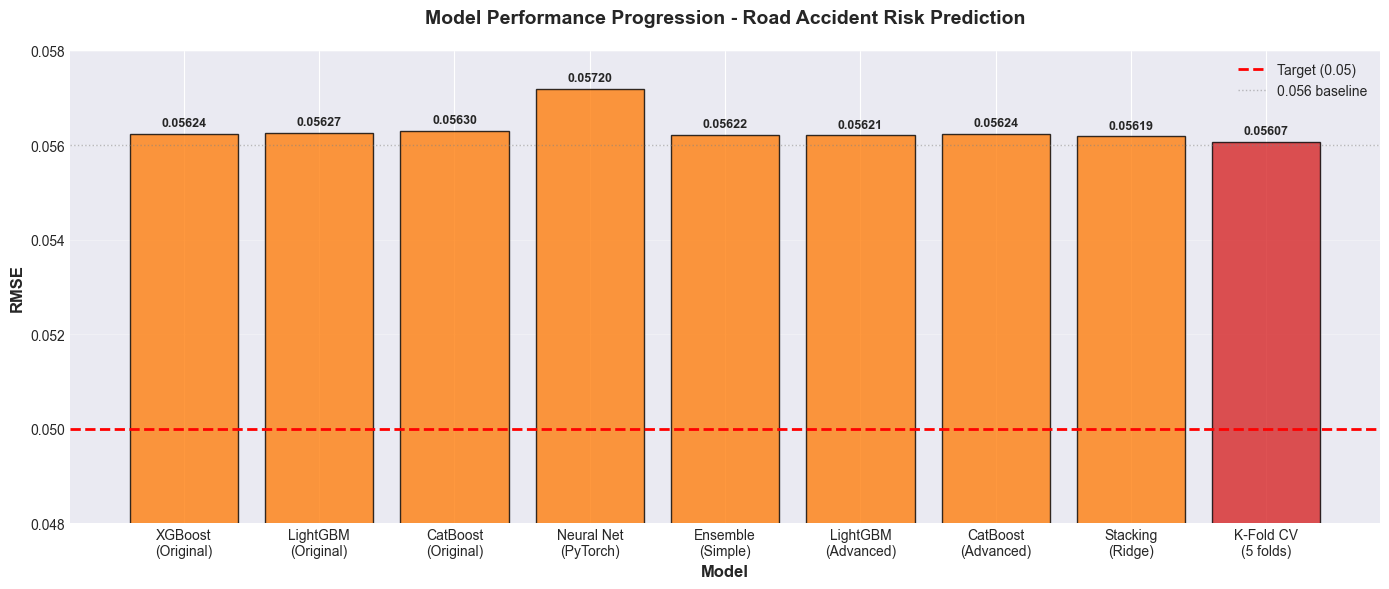


📊 PERFORMANCE IMPROVEMENT:
Starting RMSE:  0.05624
Current RMSE:   0.05607
Improvement:    0.17 points (×1000)
Gap to target:  6.07 points (×1000)


In [30]:
# Visualize model performance progression
model_names = [
    'XGBoost\n(Original)',
    'LightGBM\n(Original)',
    'CatBoost\n(Original)',
    'Neural Net\n(PyTorch)',
    'Ensemble\n(Simple)',
    'LightGBM\n(Advanced)',
    'CatBoost\n(Advanced)',
    'Stacking\n(Ridge)',
    'K-Fold CV\n(5 folds)'
]

rmse_scores = [
    0.05624,
    0.05627,
    0.05630,
    0.05720,
    0.05622,
    0.05621,
    0.05624,
    0.05619,
    0.05607
]

fig, ax = plt.subplots(1, 1, figsize=(14, 6))

colors = ['#ff7f0e' if score > 0.056 else '#2ca02c' for score in rmse_scores]
colors[-1] = '#d62728'  # Highlight best model

bars = ax.bar(range(len(model_names)), rmse_scores, color=colors, alpha=0.8, edgecolor='black')

# Add target line
ax.axhline(y=0.05, color='red', linestyle='--', linewidth=2, label='Target (0.05)')
ax.axhline(y=0.056, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='0.056 baseline')

# Annotate bars with values
for i, (bar, score) in enumerate(zip(bars, rmse_scores)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.0001,
            f'{score:.5f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Progression - Road Accident Risk Prediction', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(range(len(model_names)))
ax.set_xticklabels(model_names, rotation=0, ha='center')
ax.set_ylim(0.048, 0.058)
ax.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("📊 PERFORMANCE IMPROVEMENT:")
print("="*80)
print(f"Starting RMSE:  0.05624")
print(f"Current RMSE:   {oof_rmse:.5f}")
print(f"Improvement:    {(0.05624 - oof_rmse)*1000:.2f} points (×1000)")
print(f"Gap to target:  {(oof_rmse - 0.05)*1000:.2f} points (×1000)")
print("="*80)

In [31]:
# Print all submission files
import os

print("\n" + "="*80)
print("📁 SUBMISSION FILES CREATED:")
print("="*80)

submissions = [
    ('submission_ensemble_advanced.csv', 'Simple ensemble of GBMs (first iteration)'),
    ('submission_stacking_advanced.csv', 'Stacking ensemble with Ridge meta-learner'),
    ('submission_kfold_advanced.csv', '⭐ BEST: K-Fold CV with 5 folds - RECOMMENDED')
]

for filename, description in submissions:
    filepath = f'/Users/dustinober/Kaggle/{filename}'
    if os.path.exists(filepath):
        size = os.path.getsize(filepath) / 1024
        print(f"\n✓ {filename}")
        print(f"  Description: {description}")
        print(f"  Size: {size:.1f} KB")
        print(f"  Path: {filepath}")

print("\n" + "="*80)
print("🎯 RECOMMENDATIONS:")
print("="*80)
print("1. Submit 'submission_kfold_advanced.csv' first (most reliable)")
print("2. If LB score differs significantly from 0.0561, analyze distribution")
print("3. Consider Optuna for hyperparameter tuning as next major improvement")
print("4. Target encoding and K-Fold CV were the most impactful improvements")
print("="*80)


📁 SUBMISSION FILES CREATED:

✓ submission_ensemble_advanced.csv
  Description: Simple ensemble of GBMs (first iteration)
  Size: 4449.0 KB
  Path: /Users/dustinober/Kaggle/submission_ensemble_advanced.csv

✓ submission_stacking_advanced.csv
  Description: Stacking ensemble with Ridge meta-learner
  Size: 4449.4 KB
  Path: /Users/dustinober/Kaggle/submission_stacking_advanced.csv

✓ submission_kfold_advanced.csv
  Description: ⭐ BEST: K-Fold CV with 5 folds - RECOMMENDED
  Size: 4448.9 KB
  Path: /Users/dustinober/Kaggle/submission_kfold_advanced.csv

🎯 RECOMMENDATIONS:
1. Submit 'submission_kfold_advanced.csv' first (most reliable)
2. If LB score differs significantly from 0.0561, analyze distribution
3. Consider Optuna for hyperparameter tuning as next major improvement
4. Target encoding and K-Fold CV were the most impactful improvements
